# Measures, core-periphery partitions

The network explored is the created and filtered network in the `painter_networks.ipynb`, and is stored in the `data\painters.graphml` file.<br>
Painters are connected if (based on the dataset) they lived 5 years at the same location; periods are estimated. This is a network with extensive temporal information, with artists dating back to the middle ages all the way to the 20th century. Therefore, the network is longitudinal and connections only span to short range (painters in the same lifetime), making the network's diameter rather large (26) despite its size (2503 nodes). The network is undirected, weights are not taken into account.

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cpnet

from networkx.algorithms.assortativity import degree_assortativity_coefficient

from data_processing import plot
from data_processing import measures

#Dataset of painters/artists:
#artists = pd.read_csv("data/artists.csv").drop(columns=["Type", "Contemporary"])#Type and contemporary are artificial columns

In [3]:
G = nx.read_graphml("data/painters.graphml")
print("Nodes: ", len(list(G.nodes)), "Edges: ", len(list(G.edges)))
print("An example of node metadata:\n")
print(G.nodes()['O. Louis Guglielmi'])

Nodes:  2503 Edges:  20267
An example of node metadata:

{'name': 'O. Louis Guglielmi', 'artist': 'O. Louis Guglielmi', 'Nationality': 'American,Egyptian', 'citizenship': 'United States', 'gender': 'male', 'styles': 'Cubism, Expressionism, Magic Realism', 'movement': 'Social Realism', 'Art500k_Movements': '{Social Realism,Magic Realism:34}', 'birth_place': 'Cairo', 'death_place': 'Amagansett', 'birth_year': 1906.0, 'death_year': 1956.0, 'FirstYear': 1931.0, 'LastYear': 1955.0, 'wikiart_pictures_count': 34.0, 'locations': 'United States', 'locations_with_years': "['United States:1914-1914']", 'styles_extended': '{Cubism:3},{Expressionism:6},{Magic Realism:25}', 'StylesCount': '{Magic Realism:25}, {Cubism:8}, {Expressionism:6}', 'StylesYears': 'Magic Realism:1931-1946,Cubism:1946-1954,Expressionism:1952-1955', 'occupations': 'university teacher,painter', 'PaintingsExhibitedAt': '', 'PaintingsExhibitedAtCount': '', 'PaintingSchool': '', 'Influencedby': '', 'Influencedon': '', 'Pupils': ''

## Assortativy 

Because there are "location hubs" such as Paris, that connect a lot of artists with each other, we expect a high assortativity in the network, and along with that, a rich-club behavior.

Our method to find these firstly is plot the average degree of the neighbors of a node, against the degree of the node itself. If we see an upward trend, then nodes with higher degree have neighbors with higher degree, which is a sign of assortativity, and this is what we expect. The other method is to calculate the rich-club coefficients, which is the ratio of the number of edges between nodes with degree higher than a certain value, and we compare this against a random network's rich-club coefficients. If they are higher, i.e. the plot has values above 1, then we have a rich-club behavior - we expect higher than 1 values for large enough degrees.

A simple, basic measure of assortativity is Newman's assortativity measure, the Pearson correlation coefficient. Typically however it is better to look at the distribution rather than just look at linear correlation.

In [4]:
newman_assortativity = degree_assortativity_coefficient(G)
print(newman_assortativity)

0.13848864642084702


Let's also see the distribution, and the rich club coefficients:

In [5]:
k_nn_dict = {node: {"degree": degree,
                    "k_nn": measures.neighbours_avg_degree(G, node)} 
                    for node, degree in G.degree()}
k_nn_values_per_k = measures.average_knn(k_nn_dict)

k_nn_values = ([x['k_nn'] for x in list(k_nn_dict.values())])
k_nn = np.sum(k_nn_values)/len(k_nn_values)

rich_club_coefficients_uncorrected = nx.rich_club_coefficient(G, normalized=False, seed=1104)
rich_club_coefficients = nx.rich_club_coefficient(G, normalized=True, seed=1104)
rich_club = np.mean(list(rich_club_coefficients.values()))
rich_club_nonzero = np.mean(list(rich_club_coefficients.values())[:-12])
print(f"Average degree of neighbouring nodes (k_NN): {k_nn}")
print(f"Average rich club coefficient: {rich_club}")
print(f"Average nonzero rich club coefficient: {rich_club_nonzero}")

Average degree of neighbouring nodes (k_NN): 28.25698682380737
Average rich club coefficient: 0.9833999204869395
Average nonzero rich club coefficient: 1.0610367563148557


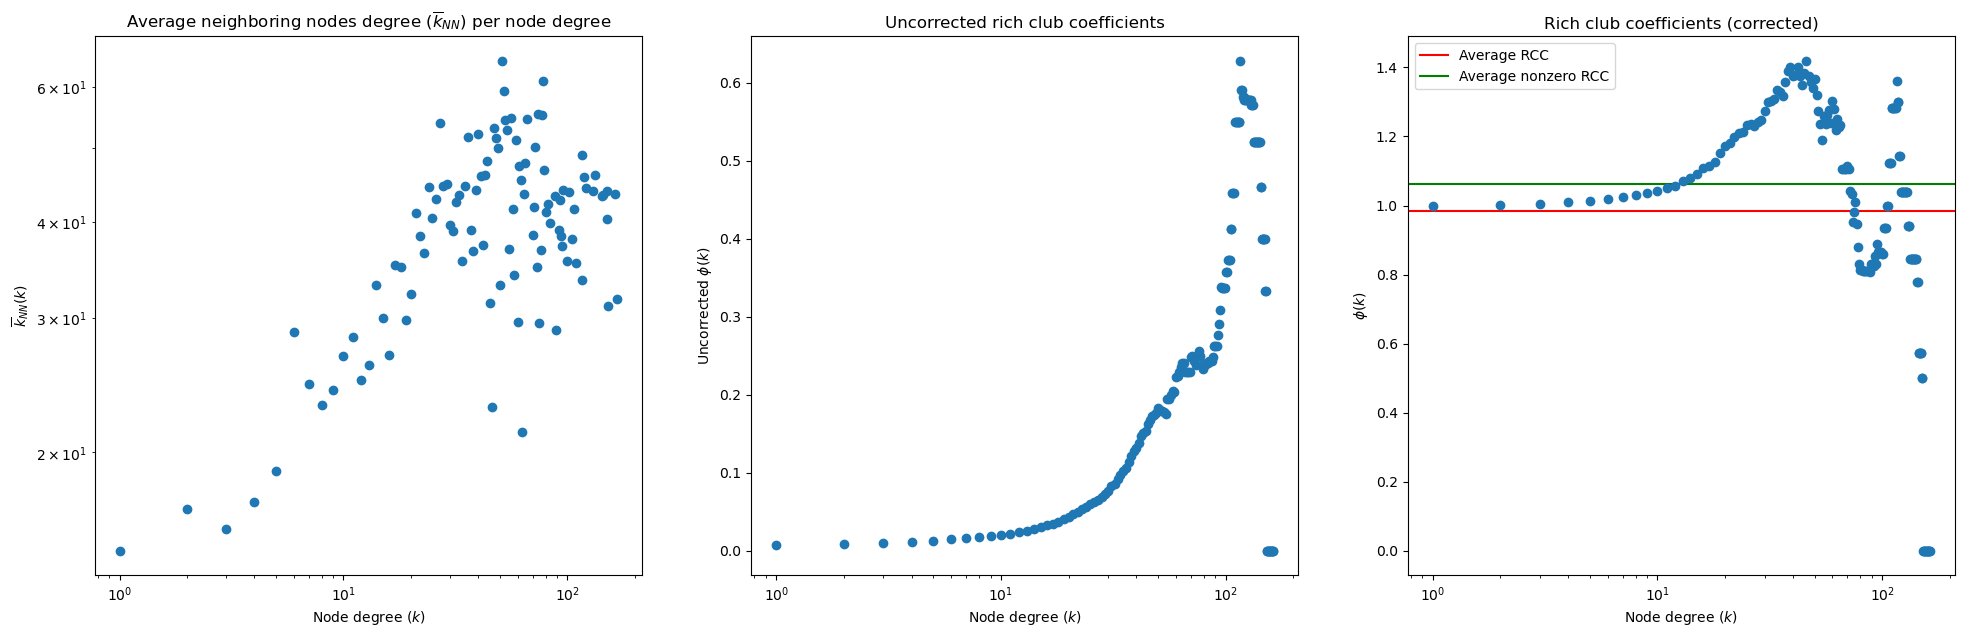

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(24, 7))
plot.plot_values_per_k(k_nn_values_per_k, ax[0], title="Average neighboring nodes degree ($\\overline{k}_{NN}$) per node degree",  ylabel="$\\overline{k}_{NN}(k)$")
plot.plot_values_per_k(rich_club_coefficients_uncorrected, ax[1], yscale = "linear", title = "Uncorrected rich club coefficients", ylabel = "Uncorrected $\phi(k)$")
ax[2].axhline(rich_club, c="red", label = "Average RCC")
ax[2].axhline(rich_club_nonzero, c="green", label = "Average nonzero RCC")
ax[2].legend()
plot.plot_values_per_k(rich_club_coefficients, ax[2], yscale = "linear", title = "Rich club coefficients (corrected)", ylabel = "$\phi(k)$")

From both plots, without fitting a line, we can see that there is assortativity and rich-club behavior (till some point) in the network, and then a sharp dropoff for the highest values. A possible explanation behind highest degree nodes being unconnected (disassortative) is the historical nature of the network – the list of artists span 11 centuries, and likely the most connected painters are the most connected in their time, but across centuries these painters cannot be connected.

## Core-periphery, rich core

### Rich core by Ma and Mondragon

Code taken from Iacopo Iacopini [here](https://github.com/iaciac/py-network-rich-core/), but updated the function (replaced outdated methods).

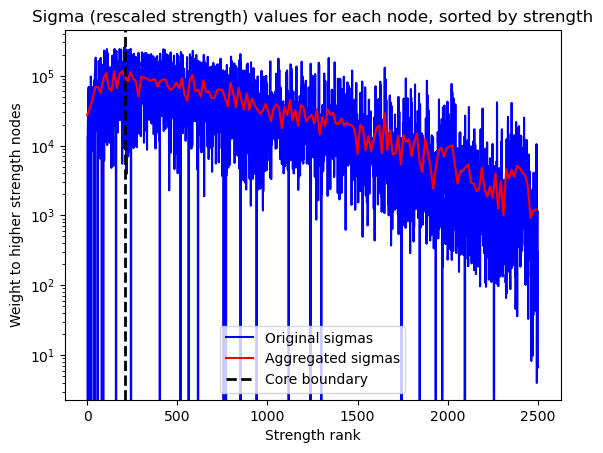

In [7]:
sigmas, ranked_nodes, r_star = measures.extract_rich_core(G,'weight')
partition_A = [ranked_nodes[:r_star+1],ranked_nodes[r_star+1:]]
window_len = 15
sigmas_denoised = [np.mean(sigmas[i*window_len:i*window_len+window_len]) for i in range(int(len(sigmas)/window_len)+1)]
x_values = [window_len * i for i in range(int(len(sigmas)/window_len)+1)]

plt.plot(sigmas, label="Original sigmas", c = "blue")
plt.plot(x_values, sigmas_denoised, label="Aggregated sigmas",c = "red")

plt.axvline(x=r_star, ymin=min(sigmas), ymax = max(sigmas), linewidth=2, color='black', linestyle='--', label = "Core boundary")
plt.xlabel('Strength rank')
plt.ylabel('Weight to higher strength nodes')
plt.yscale('log')
plt.title("Sigma (rescaled strength) values for each node, sorted by strength")
plt.legend();

In [8]:
print(f"Core size: {len(partition_A[0])}, coreness: {measures.coreness(G, partition_A)}")
print(f"'Corrected' coreness: {measures.coreness_corrected(G, partition_A)}")

Core size: 209, coreness: 2095
'Corrected' coreness: 14.54861111111111


### Core-periphery by Kojaku-Masuda configuration algorithm

In [9]:
algorithm = cpnet.KM_config()
algorithm.detect(G)

c = algorithm.get_pair_id()
x = algorithm.get_coreness()
core = [k for k,v in x.items() if v==1]
periphery = [k for k,v in x.items() if v==0]
partition_B = [core, periphery]
print(f"Core size: {len(partition_B[0])}, coreness: {measures.coreness(G, partition_B)}")
print(f"'Corrected' coreness: {measures.coreness_corrected(G, partition_B)}")

Core size: 1696, coreness: 13941
'Corrected' coreness: 1.4905377953597776


In [77]:
len(partition_A[1])

2294

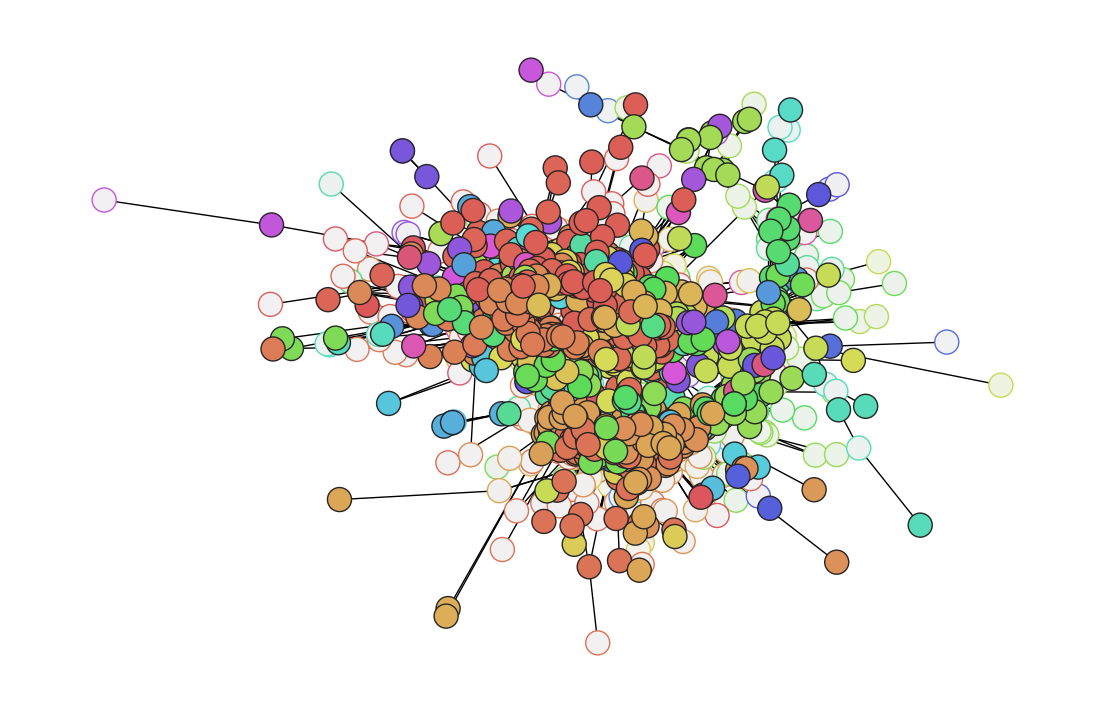

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 9))

ax, pos = cpnet.draw(G, c, x, ax, max_group_num = None, draw_edge=True, draw_nodes_kwd={}, draw_edges_kwd={}, draw_labels_kwd={})

### Core-periphery by the "Divisive" algorithm (Kojaku-Masuda)

In [11]:
algorithm = cpnet.Divisive()
algorithm.detect(G)

c = algorithm.get_pair_id()
x = algorithm.get_coreness()
core = [k for k,v in x.items() if v==1]
periphery = [k for k,v in x.items() if v==0]
partition_C = [core, periphery]
print(f"Core size: {len(partition_C[0])}, coreness: {measures.coreness(G, partition_C)}")
print(f"'Corrected' coreness: {measures.coreness_corrected(G, partition_C)}")

Core size: 119, coreness: 54
'Corrected' coreness: 0.9642857142857143


These values are quite small in comparison to previous methods.

## Partition comparison metrics: Rand, Jaccard

For community detection partition comparisons, check out the `infomap_louvain_jaccard.ipynb` notebook.

The Rand index for two partitions (X,Y) is calculated as this:

$$
\text{Rand(X,Y)} = \frac{a_{00} + a_{11}}{a_{00} + a_{11} + a_{01} + a_{10}}
$$

where 
- $a_{00}$: number of pairs of nodes where the two nodes are in **different communities in both** X and Y
- $a_{11}$: number of pairs of nodes where the two nodes are in the **same community in both** X and Y
- $a_{10}$: number of pairs of nodes where the two nodes are in the **same community in X but different communities in Y**
- $a_{01}$: number of pairs of nodes where the two nodes are in **different communities in X but the same community in Y**

The Jaccard index for two partitions (X,Y) is a modified version, to account for many pair of nodes being in different communities in any partition ($a_{00}$ being typically too large in comparison to other terms):

$$
\text{Jaccard(X,Y)} = \frac{a_{11}}{a_{11} + a_{01} + a_{10}}
$$

<br><br>We can also compare these metrics to the expected values in a random configuration, where the community sizes are the same, but nodes are randomly assigned to communities. This can be done e.g. by randomly swapping nodes between communities, or by shuffling the community assignments across nodes. The `infomap_louvain_jaccard.ipynb` notebook has such comparisons and derives the expected values mathematically.

In [12]:
rand_x_y = measures.rand_index(partition_A, partition_B)
jaccard_x_y = measures.jaccard_index(partition_A, partition_B)
print(f"Rand index for rich core and KM-config partitions: {round(rand_x_y,3)}")
print(f"Jaccard index for rich core and KM-config partitions: {round(jaccard_x_y,3)}")

Rand index for rich core and KM-config partitions: 0.522
Jaccard index for rich core and KM-config partitions: 0.494


In [13]:
rand_x_y = measures.rand_index(partition_A, partition_C)
jaccard_x_y = measures.jaccard_index(partition_A, partition_C)
print(f"Rand index for rich core and divisive partitions: {round(rand_x_y,3)}")
print(f"Jaccard index for rich core and divisive partitions: {round(jaccard_x_y,3)}")

Rand index for rich core and divisive partitions: 0.784
Jaccard index for rich core and divisive partitions: 0.781


The divisive method is more "similar" than the KM-config method to the rich core partition by Ma and Mondragon, despite having a low coreness score.